# Final Project: Facial Keypoints Detection

In this project, we'll investigate ...

In [3]:
%matplotlib inline

import csv
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib import cm
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

np.random.seed(0)

In [4]:
import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

Load images and facial keypoints coordinates.
- test_faces:        *[num_test x face_dim]*  - testing data we need to predict for final score
- test_id:           *[num_test x 1]*         - image ID from the csv file
- train_faces:       *[num_train x face_dim]* - training data - 85% from the train csv file
- dev_faces:         *[num_dev x face_dim]*   - dev data for cross validation - 15% from the train csv file
- train_coordinates: *[num_train x 30]* - coordinates of 15 key points on training faces
- dev_coordinates:   *[num_dev x 30]* - coordinates of 15 key points on dev faces
  1. name of each cooridinate column is stored in feature_name *[1 x 30]*
  2. order of key points: 1. left_eye_center, 2. right_eye_center, 3. left_eye_inner_corner, 4. left_eye_outer_corner, 5. right_eye_inner_corner, 6. right_eye_outer_corner, 7. left_eyebrow_inner_end, 8. left_eyebrow_outer_end, 9. right_eyebrow_inner_end, 10. right_eyebrow_outer_end, 11. nose_tip, 12. mouth_left_corner, 13. mouth_right_corner, 14. mouth_center_top_lip, 15. mouth_center_bottom_lip
  3. **note: some images don't have all the keypoints, and the absent points are parsed as 0 in the matrix (since no key point would appear at (0,0)), please keep this in mind when using the coordinates data!**

In [9]:
# function to load a file
def LoadFile(path):
    coordinates, faces = [], []
    with open(path) as csvfile:
        # read the file and separate image and keypoint coordinates
        facereader = csv.reader(csvfile, delimiter=',')
        for row in facereader:
            coordinates.append(row[0:-1])
            faces.append(row[-1])
        
    # first line is header, pop it out    
    coor_names, trash = coordinates.pop(0), faces.pop(0)
    # covert everything to number   
    for i in range(len(faces)):    
        faces[i] = [int(x) for x in faces[i].split(' ')]
        coordinates[i] = [float(x) if x else 0 for x in coordinates[i]]
       
    # convert to numpy array and return    
    return np.array(faces), np.array(coordinates), np.array(coor_names)

# load test data file
test_faces, test_id, trash = LoadFile('./Data/FKD_Test.csv')
print 'test data: %s, test id : %s' %(str(test_faces.shape), str(test_id.shape))

# load training data file, and separate it into training and dev data
train_faces, train_coordinates, feature_name = LoadFile('./Data/FKD_Train.csv')
nTotal = train_faces.shape[0]
shuffle = np.random.permutation(np.arange(nTotal))
train_faces, train_coordinates = train_faces[shuffle], train_coordinates[shuffle]

# take 85% as training, 15% as dev 
nTrain = np.round(nTotal*.85)
dev_faces, dev_coordinates = train_faces[nTrain:], train_coordinates[nTrain:]
train_faces, train_coordinates = train_faces[1:nTrain], train_coordinates[1:nTrain]

print 'train data: %s, train coordinates: %s' %(str(train_faces.shape), str(train_coordinates.shape))
print 'dev data: %s, dev coordinates: %s' %(str(dev_faces.shape), str(dev_coordinates.shape))

test data: (1783L, 9216L), test id : (1783L, 1L)
train data: (5991L, 9216L), train coordinates: (5991L, 30L)
dev data: (1057L, 9216L), dev coordinates: (1057L, 30L)


Function for Histogram Stretching

In [89]:
def HistogramStretching(image):
#     a, b = min(image), max(image) 
    a, b = np.percentile(image, 5), np.percentile(image, 95)
    l, u = 0, 255
    const = 1.0*(b*l - a*u)/(b - a)
    k = 1.0*(u-l)/(b-a)
    return [k*p+const for p in image]

PCA theory goes here...

In [90]:
# PCA preprocessing with stretching - can take a while to calculate
pca = PCA(n_components=125)
pca.fit(np.transpose([HistogramStretching(x) for x in train_faces]))
# get eigen-face
train_eigenfaces = np.dot(pca.components_, train_faces)

# training eigen-coordinates needs get rid of zeros, normalize weight first
cw = pca.components_**2
train_eigencoordinates, dev_eigencoordinates = [], []
for i in range(train_coordinates.shape[1]):
    picker = train_coordinates[:,i]>0
    weight = cw[:,picker]
    norm = np.sum(weight, axis=1)
    weight = weight/norm[:,np.newaxis]
    train_eigencoordinates.append(np.dot(weight,train_coordinates[picker,i]))
train_eigencoordinates = np.array(np.transpose(train_eigencoordinates))

print 'Training: eigen-face %s, eigen-coordinates %s' %(str(train_eigenfaces.shape), str(train_eigencoordinates.shape))

Training: eigen-face (125L, 9216L), eigen-coordinates (125L, 30L)


Plotting:
- it looks like those with smaller ranges are bad pictures

In [91]:
def plot(image, points, pred=[]):
    # print a picture to see
    plt.figure(figsize=(8, 8))
    plt.imshow(np.reshape(image,(96,96)), cmap = cm.gray)
    plt.axis('off')
    if len(points)>0:
        for i in range(len(points)/2):
            plt.plot(points[2*i], points[2*i+1],'r.')
    if len(pred)>0:
        for i in range(len(pred)/2):
            plt.plot(pred[2*i],pred[2*i+1],'c.')

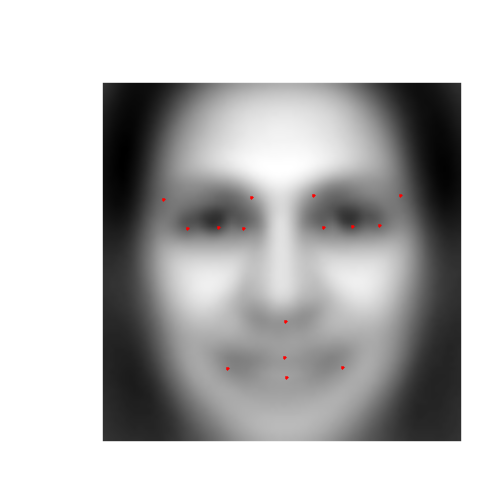

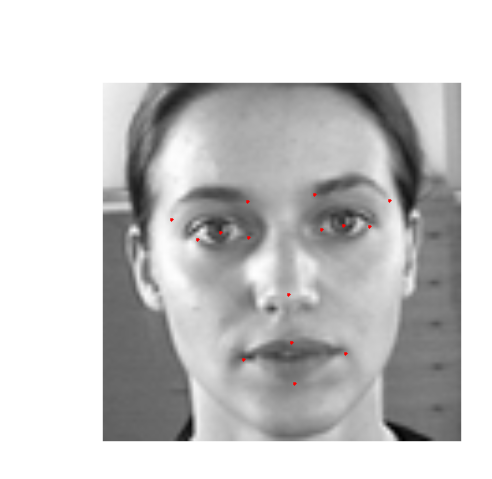

In [173]:
# testing example    
ranges = [np.ptp(x) for x in train_faces]
id = np.argsort(ranges)[-12]
plot(train_eigenfaces[0], train_eigencoordinates[0])
plot(HistogramStretching(train_faces[id]), train_coordinates[id])

In [159]:
def getPatches(faces, keypoints, patch_size, point_index=range(0,15)):    
        patches = []
        patch_index = np.array([[i,j] for i in range(-patch_size, patch_size+1) 
                                for j in range(-patch_size, patch_size+1)])
        
        keypoints_filtered = np.round(keypoints[:,[(index*2, index*2+1) for index in point_index]])
        
        nrow = np.sqrt(faces.shape[1])
        ncol = nrow
        
        for face, keypoints_filtered in zip(faces, keypoints_filtered):
            temp = []
            for x,y in keypoints_filtered :
                if (x-patch_size >=0) and (x+patch_size+1 < ncol) and (y-patch_size >=0) and (y+patch_size+1 < nrow) :
                    # get indices for the patch (including self)
                    face_array = np.reshape(face, (nrow,ncol))
                    temp.append(face_array[y-patch_size:y+patch_size+1, x-patch_size:x+patch_size+1])
                else :
                    temp.append([])
            patches.append(temp)

        return patches

1. left_eye_center, 2. right_eye_center, 3. left_eye_inner_corner, 4. left_eye_outer_corner, 5. right_eye_inner_corner, 6. right_eye_outer_corner, 7. left_eyebrow_inner_end, 8. left_eyebrow_outer_end, 9. right_eyebrow_inner_end, 10. right_eyebrow_outer_end, 11. nose_tip, 12. mouth_left_corner, 13. mouth_right_corner, 14. mouth_center_top_lip, 15. mouth_center_bottom_lip

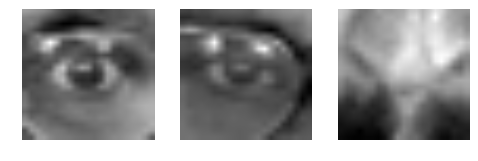

In [179]:
# play around with points
points = [0,1,10]
temp_patches = getPatches(train_faces[:20,], train_coordinates[:20,], 10, points)

# train face number: some of them doesn't have some points
sample_n = 5

fig=plt.figure(figsize=(8, 8*len(points)))
i=0
for patches in temp_patches[sample_n] :
    i+=1
    if patches != [] :
        fig.add_subplot(1, len(points), i)
        plt.imshow(patches, cmap = cm.gray)
        plt.axis('off')


In [ ]:
# We'll start in Theano with implententing logistic regression.  
# Recall the four key components: (1) parms, (2) model, (3) cost, and (4) objective. 

## (1) Parms 
# Init weights to small, but non-zero, values.
w = theano.shared(np.asarray((np.random.randn(*(numFeatures, numClasses))*.01)))

## (2) Model
# Theano objects accessed with standard Python variables
X = T.matrix()
Y = T.matrix()
# Two things to note here.
# First, logistic regression can be thought of as a neural net with no hidden layers.  So the output values are 
# just the dot product of the inputs and the edge weights.
# Second, we have 10 classes.  So we can either train separate 1 vs all classification using sigmoid activation, 
# which would be a hassle, or we can use the softmax activation, which is essentially a multi-class version of sigmoid. 

def model(X, w):
    return T.nnet.softmax(T.dot(X, w))
y_hat = model(X, w)

## (3) Cost
# Cross entropy only considers the error between the true class and the prediction, and not the errors for the false 
# classes.  This tends to cause the network to converge faster.
cost = T.mean(T.nnet.categorical_crossentropy(y_hat, Y))

## (4) Objective
# Minimization using gradient descent.
alpha = 0.01
gradient = T.grad(cost=cost, wrt=w)
update = [[w, w - gradient * alpha]] 
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True) # computes cost, then runs update
y_pred = T.argmax(y_hat, axis=1) # select largest probability as prediction
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

def gradientDescent(epochs):
    trainTime = 0.0
    predictTime = 0.0
    for i in range(epochs):
        start_time = time.time()
        cost = train(train_data[0:len(train_data)], train_labels_b[0:len(train_data)])
        trainTime =  trainTime + (time.time() - start_time)
        print '%d) accuracy = %.4f' %(i+1, np.mean(np.argmax(test_labels_b, axis=1) == predict(test_data)))
    print 'train time = %.2f' %(trainTime)

gradientDescent(50)

start_time = time.time()
predict(test_data)   
print 'predict time = %.2f' %(time.time() - start_time)

Mean Patch Searching algorithm

In [4]:
class MeanPatchSearching:
    # Initialize an instance of the class.
    def __init__(self, patch_size=10, search_size=10, stretch=True):
        self.patch_size = patch_size
        self.search_size = search_size
        self.isStretch = stretch
        self.patch_index = np.array([[i,j] for i in range(-patch_size, patch_size+1) 
                                           for j in range(-patch_size, patch_size+1)])
        self.search_index = np.array([[i,j] for i in range(-search_size, search_size+1) 
                                            for j in range(-search_size, search_size+1)])
    
    # train the model
    def fit(self, train_faces, train_coordinates):
        start = datetime.now()
        # stretch input if needed
        if False: #self.isStretch:
            train_faces = np.array([self._histogramStretching(x) for x in train_faces])
        # number of faces to train
        self.num_examples = train_faces.shape[0]
        print 'number of training faces: %d' %self.num_examples
        # assuming coordinates are (x,y) pairs for each key point
        self.num_keypoints = train_coordinates.shape[1]/2
        # image dimension
        self.ncolumn = np.sqrt(train_faces.shape[1])
        self.nrow = self.ncolumn
        
        # get patches and their centers for all keypoints
        self.patches, self.patch_centers = [], []
        for i in range(self.num_keypoints):
            # get coordinates of current keypoint
            coordinates = train_coordinates[:,i*2:(i+1)*2]
            # filter zero values (empty from file)
            picker = coordinates[:,0]>0                        
            # get patch if at least one face has this point
            if sum(picker)>0:
                # get patch for this key point
                self.patches.append(self._getPatch(train_faces[picker], coordinates[picker]))
                # get center for this keypoint
                self.patch_centers.append(np.mean(coordinates[picker], axis=0))
        
        # convert to numpy array      
        self.patches = np.array(self.patches)
        self.patch_centers = np.array(self.patch_centers)
        self.num_keypoints = self.patches.shape[0]
        self.training_time = (datetime.now()-start).total_seconds()/60.0
        print 'training patches shape: %s' %str(self.patches.shape)
        print 'training time: %.1f minutes' %self.training_time
        # show training patches
#         self._plotPatches()
        
    # Make prediction for each test face and return coordinates.
    def predict(self, test_faces):
        start = datetime.now()
        # stretch input if needed
        if self.isStretch:
            test_faces = np.array([self._histogramStretching(x) for x in test_faces])
        self.num_predict = test_faces.shape[0]
        print 'number of predicting faces: %d' %self.num_predict
        predictions = []
        for i in range(self.num_predict):
            if np.mod((i+1), self.num_predict/10)==0:
                print 'Complete %d%% ...' %(100.0*(i+1)/self.num_predict)
            pred = self._predictOneFace(test_faces[i])            
            predictions.append(np.reshape(pred, (1,2*self.num_keypoints))[0])        
        self.pred_coor = np.array(predictions)
        self.predict_time = (datetime.now()-start).total_seconds()/60.0
        print 'Done! - Predict time: %.1f minutes' %self.predict_time
        return self.pred_coor
    
    # calculate total Root Mean Squared Error (RMSE)
    def RMSE(self, actual, pred=[]):
        if len(pred)==0:
            pred = self.pred_coor
        picker = actual>0        
        tRMSE = np.sqrt(np.sum((actual[picker]-pred[picker])**2)/np.sum(picker)) 
        return 'Total RMSE: %.2f, patch size: %d, search size: %d' %(tRMSE, self.patch_size, self.search_size)
    
    # save the submission file based on prediction made for test images
    def getSubmission(self, LookupTable, feature_name):
        # create a dictionary for feature name indexing
        feature_index = {x:np.where(feature_name==x)[0][0] for x in feature_name}
        lookupRow = []
        with open(LookupTable) as csvfile:
            # read the lookup file
            lookupReader = csv.reader(csvfile, delimiter=',')
            lookupRow.append(lookupReader.next())
            for row in lookupReader:
                # get the prediction based on image ID and feature name, and attach to the row
                location = self.pred_coor[int(row[1])-1, feature_index[row[2]]]
                lookupRow.append(np.append(row, location))
        lookupRow = np.array(lookupRow)
        # save row ID and location ID columns only to the submission file
        saveFile = 'submission_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.csv'
        with open(saveFile, 'wb') as f:
            writer = csv.writer(f)
            writer.writerows(lookupRow[:,[0,3]])
        print 'Submission file saved as: %s' %saveFile
        return lookupRow
        
    # get the prediction for one face
    def _predictOneFace(self, face):
        # get prediction for each keypoint available in the model
        pred_coor = []
        for gold_p, center in zip(self.patches, self.patch_centers):
            # get the candidate points based on search size
            candidates = self._getCandidates(center)
            # get a patch for each candidate point     
            pred_p = [self._getPatch([face], [x]) for x in candidates]

            # compare the patches from candidate points with gold_p
            # TODO: use better distance
            dist = [np.sum(np.abs(gold_p-x)) for x in pred_p]
            pred_coor.append(candidates[np.argmin(dist)])
        return pred_coor
    
    # get the candidate points - return the coordinates
    def _getCandidates(self, center):  
        r, c = np.round(center)
        candidates = np.array([[r+i, c+j] for i,j in self.search_index])
        # only keep those within the bound
        picker = (np.sum(candidates>=0,axis=1) + np.sum(candidates<[self.nrow,self.ncolumn],axis=1))==4        
        return candidates[picker]
    
    # get the patch for one keypoint from all faces
    def _getPatch(self, faces, keypoints):    
        patches = []
        for face, keypoint in zip(faces, keypoints):
            # get keypoint pixel row and column index
            r, c = np.round(keypoint)        
            # get indices for the patch (including self)
            neighbors = np.array([[r+i, c+j] for i,j in self.patch_index])
            if np.sum(neighbors>=0)+np.sum(neighbors<[self.nrow,self.ncolumn]) == np.prod(neighbors.shape)*2:
                patches.append(face[[r*self.ncolumn + c for r,c in neighbors]])
#             else:
#                 print 'warning - nonconforming patch'
#         print np.array(patches).shape
        return np.mean(patches, axis=0)

    # histogram stretching pre-processing
    def _histogramStretching(self, image):
        # a, b = min(image), max(image) 
        a, b = np.percentile(image, 5), np.percentile(image, 95)
        l, u = 0, 255
        const = 1.0*(b*l - a*u)/(b - a)
        k = 1.0*(u-l)/(b-a)
        return [k*p+const for p in image]
    
    # plot average patch from training
    def _plotPatches(self):
        n_side = 2*self.patch_size+1
        keypoints = np.reshape([x[:-2] for x in feature_name],(self.num_keypoints,2))
        plt.figure(figsize=(16, 8))
        i = 1
        for point, patch in zip(keypoints[:,0], self.patches):
            plt.subplot(3,5,i)
            plt.imshow(np.reshape(patch,(n_side,n_side)), cmap = cm.gray)
            plt.title(point)
            plt.axis('off')
            i += 1
        plt.show()


Error analysis help functions:
1. Rank prediction error on keypoints and images
 - actual     [num_test, num_coordinates] - actual keypoint coordinates from testing faces
 - prediction [num_test, num_coordinates] - predicted keypoint cooridnates for testing faces
 - **note:** two inputs must have same dimension, and the function is not comparing the absent key points (0) on the face


In [34]:
# print a rank for predidction RMSE
def RankPredictionRMSE(actual, prediction):
    print '\nError Analysis:'
    feaRMSE, keyRMSE = [], []
    # for each feature
    for i in range(len(feature_name)):               
        picker = actual[:,i]>0
        feaRMSE.append(np.sqrt(np.mean((actual[picker,i]-prediction[picker,i])**2)))
    feaRMSE = np.array(feaRMSE)
    feaRank = np.argsort(feaRMSE)
    
    # for each keypoint
    keypoints = [x[:-2] for x in feature_name]
    indexes = np.unique(keypoints, return_index=True)[1]
    keypoints = np.array([keypoints[i] for i in sorted(indexes)])
    for i in range(len(keypoints)):
        act = actual[:,i*2:(i+1)*2]
        pre = prediction[:,i*2:(i+1)*2]
        picker = act[:,0]>0
        keyRMSE.append(np.sqrt(np.mean((act[picker]-pre[picker])**2)))
    keyRMSE = np.array(keyRMSE)
    keyRank = np.argsort(keyRMSE)
    showKey = np.append(keypoints[keyRank][::-1], np.zeros(shape=(len(keypoints),1)))
    showRMSE = np.append(keyRMSE[keyRank][::-1], np.zeros(shape=(len(keypoints),1)))
    
    # for each testing image    
    imgRMSE = np.array([np.sqrt(np.mean((pre[act>0]-act[act>0])**2)) for pre, act in zip(prediction, actual)])
    imgRank = np.argsort(imgRMSE)
    
    # print the RMSE ranking results    
    template = "{0:35}{1:20}{2:35}{3:10}"
    print template.format("feature name", "RMSE", "keypoint", "RMSE") # header
    for f, r1, k, r2 in zip(feature_name[feaRank][::-1], feaRMSE[feaRank][::-1], showKey, showRMSE):
        print template.format(f, *['%.3f' %r1, '%s' %(k if k!='0.0' else ''), '%s' %('%.3f' %r2 if r2!=0 else '')])
    
    # plot top 10 badly predicted testing faces   
    n_top = np.min([10, actual.shape[0]])
    print '\nTop %d faces with highest RMSE:' %n_top
    plt.figure(figsize=(20, 10))
    i=1
    for iid in imgRank[::-1][:n_top]:
        plt.subplot(2,5,i)        
        plt.imshow(np.reshape(dev_faces[iid], (96,96)), cmap = cm.gray)
        picker = actual[iid]>0
        pre = np.reshape(prediction[iid, picker],(sum(picker)/2,2))
        kp = np.reshape(actual[iid, picker], (sum(picker)/2,2))
        for a,p in zip(kp, pre):
            plt.plot(a[0],a[1],'r.')
            plt.plot(p[0],p[1],'c.')
        plt.axis('off')
        plt.title('[%d] RMSE: %.3f' %(iid,imgRMSE[iid]))
        i+=1
        

number of training faces: 150
training patches shape: (15, 361)
training time: 0.0 minutes
number of predicting faces: 50
Complete 10% ...
Complete 20% ...
Complete 30% ...
Complete 40% ...
Complete 50% ...
Complete 60% ...
Complete 70% ...
Complete 80% ...
Complete 90% ...
Complete 100% ...
Done! - Predict time: 1.7 minutes
Total RMSE: 5.35, patch size: 9, search size: 5

Error Analysis:
feature name                       RMSE                keypoint                           RMSE      
mouth_center_bottom_lip_y          7.021               mouth_center_bottom_lip            6.270     
mouth_right_corner_y               6.796               mouth_left_corner                  6.174     
mouth_left_corner_y                6.785               left_eyebrow_outer_end             5.924     
mouth_center_top_lip_y             6.594               mouth_center_top_lip               5.920     
nose_tip_y                         6.495               nose_tip                           5.859     
le

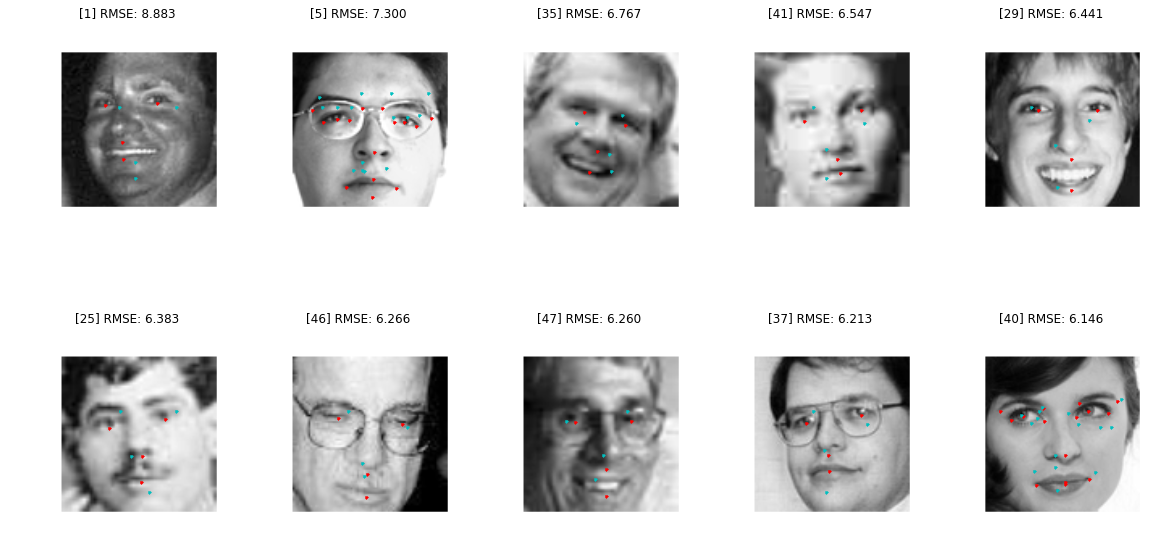

In [36]:
# predicting dev faces
mps = MeanPatchSearching(patch_size=9, search_size=5, stretch=True)
mps.fit(train_faces[:150], train_coordinates[:150])

n_pred = 50
predictions = mps.predict(dev_faces[:n_pred])
print mps.RMSE(dev_coordinates[:n_pred])

RankPredictionRMSE(dev_coordinates[:n_pred], predictions)

In [138]:
# test using pca features
mps = MeanPatchSearching(patch_size=9, search_size=4, stretch=True)
mps.fit(train_eigenfaces, train_eigencoordinates)

predictions = mps.predict(dev_faces)
print mps.RMSE(dev_coordinates)

number of training faces: 125
training patches shape: (15L, 361L)
training time: 0.1 minutes
number of predicting faces: 1057
Complete 9% ...
Complete 19% ...
Complete 29% ...
Complete 39% ...
Complete 49% ...
Complete 59% ...
Complete 69% ...
Complete 79% ...
Complete 89% ...
Complete 99% ...
Done! - Predict time: 37.9 minutes
Total RMSE: 5.26, patch size: 9, search size: 4


In [139]:
# predicting test faces for submission
predictions = mps.predict(test_faces)
mps.getSubmission('./Data/FKD_IdLookupTable.csv', feature_name)

number of predicting faces: 1783
Complete 9% ...
Complete 19% ...
Complete 29% ...
Complete 39% ...
Complete 49% ...
Complete 59% ...
Complete 69% ...
Complete 79% ...
Complete 89% ...
Complete 99% ...
Done! - Predict time: 62.0 minutes
Submission file saved as: submission_20150714213626.csv


array([['RowId', 'ImageId', 'FeatureName', 'Location'],
       ['1', '1', 'left_eye_center_x', '64.0'],
       ['2', '1', 'left_eye_center_y', '42.0'],
       ..., 
       ['27122', '1783', 'nose_tip_y', '61.0'],
       ['27123', '1783', 'mouth_center_bottom_lip_x', '44.0'],
       ['27124', '1783', 'mouth_center_bottom_lip_y', '83.0']], 
      dtype='|S32')

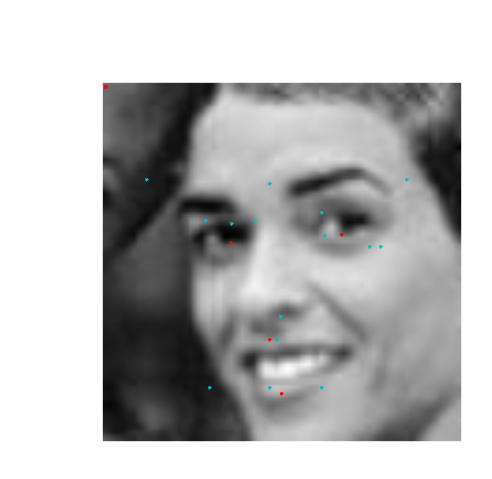

In [81]:
# result checking
id = 0
temp = datetime.now()
plot(dev_faces[id], dev_coordinates[id], predictions[id])

In [509]:
# clear up workspace
%reset 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
